In [ ]:
import torch
import torch.optim as optim
from torch.autograd import Variable
import torchvision.datasets as dsets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from PIL import Image
import PIL.ImageOps
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib

from networks import embed_relu, ClassificationNet
from trainer import fit

cuda = torch.cuda.is_available()
%matplotlib inline

print(cuda)

True


In [ ]:
train = dsets.MNIST(
    root='/data/',
    train=True,
    download=True, 
    transform=transforms.ToTensor())

test = dsets.MNIST(
    root='/data/',
    train=False,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]))
    
n_classes = 10

In [ ]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds, 0], embeddings[inds, 1], alpha=0.5, label=i)
        plt.legend()
    
def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for imgs, target in dataloader:
            if cuda:
                imgs = imgs.cuda()
            embeddings[k:k+len(imgs)] = model.get_embedding(imgs).data.cpu().numpy()
            labels[k:k+len(imgs)] = target.numpy()
            k += len(imgs)
            
    return embeddings, labels

In [ ]:
batch_size = 128
kwargs = {'num_workers':1, 'pin_memory':True} if cuda else {}

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, **kwargs)

## MNIST

### ReLU Activation function

In [ ]:
embed_net = embed_relu()
model = ClassificationNet(embed_net, n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 0.01
momemtum = 0.9
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momemtum)
n_epochs = 10
log_interval = 50

In [ ]:
fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 2.376569
Train: [6400/60000 (11%)]	Loss: 2.331351
Train: [12800/60000 (21%)]	Loss: 2.314999
Train: [19200/60000 (32%)]	Loss: 2.303924
Train: [25600/60000 (43%)]	Loss: 2.263092
Train: [32000/60000 (53%)]	Loss: 2.089622
Train: [38400/60000 (64%)]	Loss: 1.940926
Train: [44800/60000 (75%)]	Loss: 1.863159
Train: [51200/60000 (85%)]	Loss: 1.668531
Train: [57600/60000 (96%)]	Loss: 1.436155
Epoch: 1/10. Train set: Average loss: 1.9972
Epoch: 1/10. Validation set: Average loss: 1.2735
Train: [0/60000 (0%)]	Loss: 1.334730
Train: [6400/60000 (11%)]	Loss: 1.185004
Train: [12800/60000 (21%)]	Loss: 1.039986
Train: [19200/60000 (32%)]	Loss: 0.964145
Train: [25600/60000 (43%)]	Loss: 0.903184
Train: [32000/60000 (53%)]	Loss: 0.830217
Train: [38400/60000 (64%)]	Loss: 0.791390
Train: [44800/60000 (75%)]	Loss: 0.719951
Train: [51200/60000 (85%)]	Loss: 0.708349
Train: [57600/60000 (96%)]	Loss: 0.669384
Epoch: 2/10. Train set: Average loss: 0.8599
Epoch: 2/10. Validation set: Ave

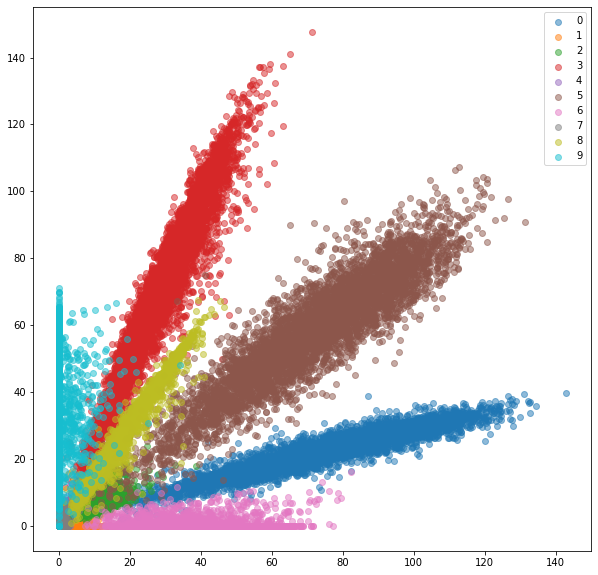

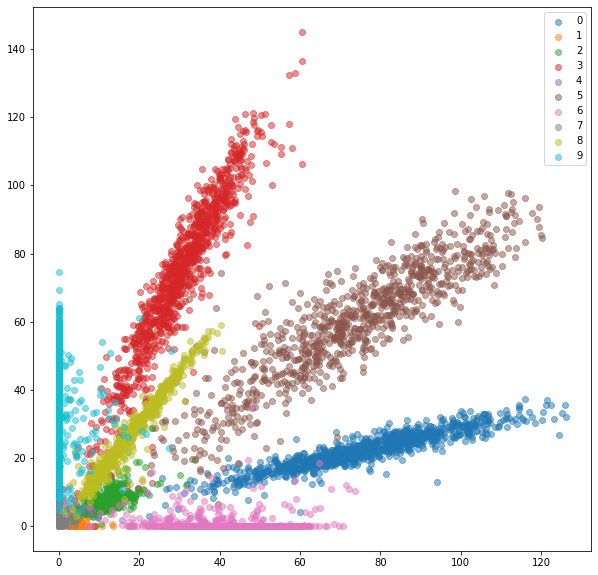

In [ ]:
train_embed, train_label = extract_embeddings(train_loader, model)
val_embed, val_label = extract_embeddings(test_loader, model)

plot_embeddings(train_embed, train_label)
plot_embeddings(val_embed, val_label)

### Kernel Activation Function(KAF, KAF2D)

In [ ]:
from networks import embed_kaf, embed_kaf2d, SiameseNet
from loss import ContrastiveLoss
from dataset import SiameseMNIST

siamses_train_dataset = SiameseMNIST(train)
siamese_test_dataset = SiameseMNIST(test)

C:\Users\user\anaconda3\envs\tf2.0-gpu\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\user\anaconda3\envs\tf2.0-gpu\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\user\anaconda3\envs\tf2.0-gpu\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
C:\Users\user\anaconda3\envs\tf2.0-gpu\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


#### KAF

In [ ]:
siamese_train_loader = torch.utils.data.DataLoader(siamses_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

margin = 3.0
embed_net = embed_kaf()
model = SiameseNet(embed_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 0.01
momemtum = 0.9
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momemtum)
n_epochs = 10
log_interval = 50

C:\Users\user\Desktop\IME654-BA\kernel\Improving_Siamese_Networks_for_One_shot_learning\activation.py:53: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  normal(self.alpha.data, std=0.3)


In [ ]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 2.013659
Train: [6400/60000 (11%)]	Loss: 1.125285
Train: [12800/60000 (21%)]	Loss: 0.631370
Train: [19200/60000 (32%)]	Loss: 0.494047
Train: [25600/60000 (43%)]	Loss: 0.439659
Train: [32000/60000 (53%)]	Loss: 0.398696
Train: [38400/60000 (64%)]	Loss: 0.365207
Train: [44800/60000 (75%)]	Loss: 0.341251
Train: [51200/60000 (85%)]	Loss: 0.322645
Train: [57600/60000 (96%)]	Loss: 0.303423
Epoch: 1/10. Train set: Average loss: 0.4873
Epoch: 1/10. Validation set: Average loss: 0.2841
Train: [0/60000 (0%)]	Loss: 0.196489
Train: [6400/60000 (11%)]	Loss: 0.275447
Train: [12800/60000 (21%)]	Loss: 0.285089
Train: [19200/60000 (32%)]	Loss: 0.250409
Train: [25600/60000 (43%)]	Loss: 0.241951
Train: [32000/60000 (53%)]	Loss: 0.227982
Train: [38400/60000 (64%)]	Loss: 0.244840
Train: [44800/60000 (75%)]	Loss: 0.223639
Train: [51200/60000 (85%)]	Loss: 0.207700
Train: [57600/60000 (96%)]	Loss: 0.209504
Epoch: 2/10. Train set: Average loss: 0.2394
Epoch: 2/10. Validation set: Ave

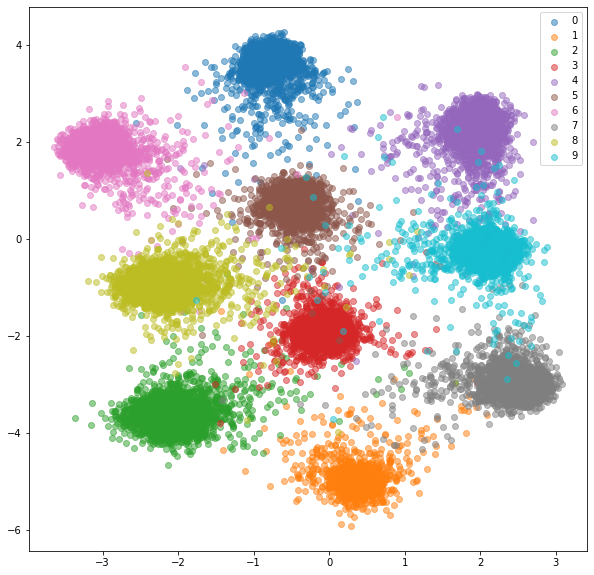

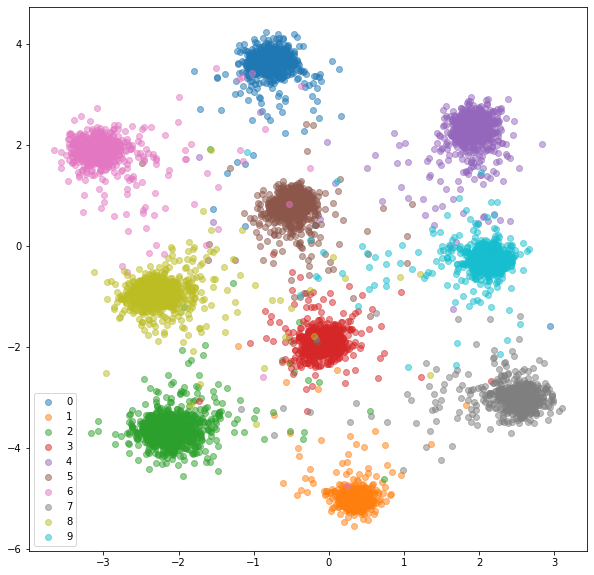

In [ ]:
train_embed, train_label = extract_embeddings(train_loader, model)
val_embed, val_label = extract_embeddings(test_loader, model)

plot_embeddings(train_embed, train_label)
plot_embeddings(val_embed, val_label)

#### KAF2D

In [ ]:
margin = 3.0
embed_net = embed_kaf2d()
model = SiameseNet(embed_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 0.01
momemtum = 0.9
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momemtum)
n_epochs = 10
log_interval = 50

C:\Users\user\Desktop\IME654-BA\kernel\Improving_Siamese_Networks_for_One_shot_learning\activation.py:111: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  normal(self.alpha.data, std=0.3)


In [ ]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 1.905655
Train: [6400/60000 (11%)]	Loss: 1.114814
Train: [12800/60000 (21%)]	Loss: 0.632107
Train: [19200/60000 (32%)]	Loss: 0.528126
Train: [25600/60000 (43%)]	Loss: 0.469624
Train: [32000/60000 (53%)]	Loss: 0.431381
Train: [38400/60000 (64%)]	Loss: 0.369730
Train: [44800/60000 (75%)]	Loss: 0.347902
Train: [51200/60000 (85%)]	Loss: 0.322264
Train: [57600/60000 (96%)]	Loss: 0.312141
Epoch: 1/10. Train set: Average loss: 0.4997
Epoch: 1/10. Validation set: Average loss: 0.3145
Train: [0/60000 (0%)]	Loss: 0.228146
Train: [6400/60000 (11%)]	Loss: 0.300877
Train: [12800/60000 (21%)]	Loss: 0.269694
Train: [19200/60000 (32%)]	Loss: 0.266429
Train: [25600/60000 (43%)]	Loss: 0.251229
Train: [32000/60000 (53%)]	Loss: 0.246606
Train: [38400/60000 (64%)]	Loss: 0.229971
Train: [44800/60000 (75%)]	Loss: 0.243441
Train: [51200/60000 (85%)]	Loss: 0.227839
Train: [57600/60000 (96%)]	Loss: 0.211679
Epoch: 2/10. Train set: Average loss: 0.2485
Epoch: 2/10. Validation set: Ave

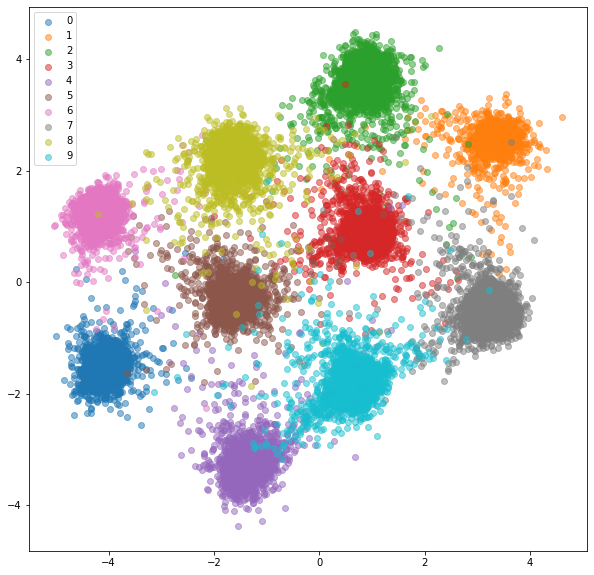

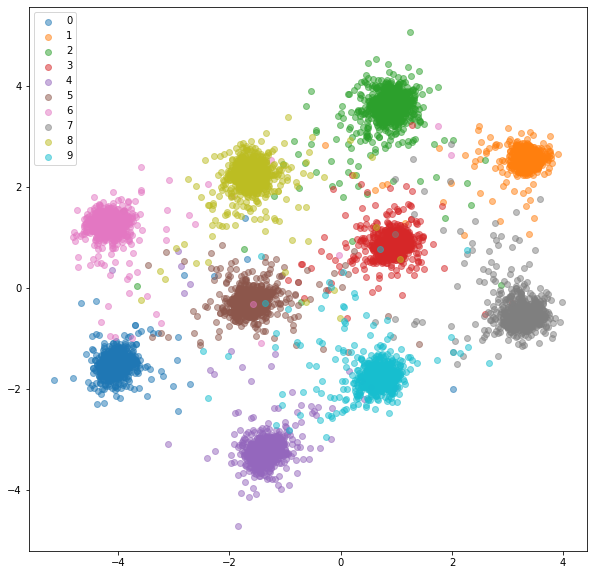

In [ ]:
train_embed, train_label = extract_embeddings(train_loader, model)
val_embed, val_label = extract_embeddings(test_loader, model)

plot_embeddings(train_embed, train_label)
plot_embeddings(val_embed, val_label)